Import libraries

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#% matplotlib inline

In [11]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

Data Load

In [12]:
df_train = pd.read_csv('datasets_897_1638_Sheet_1.csv', header=0, encoding = 'unicode_escape')

df_train.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


In [13]:
from io import StringIO
col = ['class', 'response_text']

df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['response_text'])]

df_train.columns = ['class', 'response_text']

df_train['category_id'] = df_train['class'].factorize()[0]

category_id_df_train = df_train[['class', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'class']].values)

df_train.head()


,class,response_text,category_id
0,not_flagged,I try and avoid this sort of conflict,0
1,flagged,Had a friend open up to me about his mental ad...,1
2,flagged,I saved a girl from suicide once. She was goin...,1
3,not_flagged,i cant think of one really...i think i may hav...,0
4,not_flagged,Only really one friend who doesn't fit into th...,0


In [16]:
df_train['response_text'][29]

"I used to tutor homeless men at a shelter to help them obtain their GED's. They were all age 50+ and some of them were even reading at a first grade level."

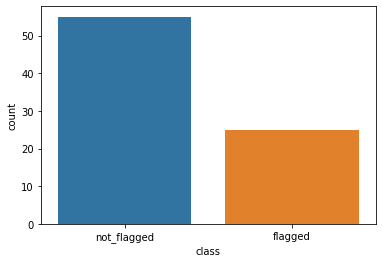

In [18]:
import seaborn as sns


sns.countplot(x='class', data=df_train)

In [5]:
response_text = ['I try and avoid this sort of conflict', 'Friend was thinking about suicide, after a few days I managed to talk her down.']

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df = 0, lowercase = False)
vectorizer.fit(response_text)

vectorizer.vocabulary_

{'try': 18,
 'and': 3,
 'avoid': 4,
 'this': 16,
 'sort': 12,
 'of': 11,
 'conflict': 5,
 'Friend': 0,
 'was': 19,
 'thinking': 15,
 'about': 1,
 'suicide': 13,
 'after': 2,
 'few': 8,
 'days': 6,
 'managed': 10,
 'to': 17,
 'talk': 14,
 'her': 9,
 'down': 7}

In [7]:
vectorizer.transform(response_text).toarray()

array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]])

Define a Baseline Model

In [8]:
from sklearn.model_selection import train_test_split

response_text = df_train['response_text'].values
y = df_train['category_id'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(response_text, y, test_size = 0.25,
                                                                   random_state = 1000)



Use Bag-of-words (BOW) model, which is a common way in NLP create vectors out of text. You can use the CountVectorizer. 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

X_train

<60x515 sparse matrix of type '<class 'numpy.int64'>'
	with 1317 stored elements in Compressed Sparse Row format>

The classification model we will use Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.95


Deep Neural Networks 

In [22]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1] #Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim = input_dim, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

Compile() method. This method specifies the optimizer and the loss function.

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                5160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 5,171
Trainable params: 5,171
Non-trainable params: 0
_________________________________________________________________


Fit() function

In [24]:
history = model.fit(X_train, y_train,
                   epochs = 100,
                   verbose = False,
                   validation_data = (X_test, y_test),
                   batch_size = 10)

evaluate method

You can do this both for the training data and testing data

In [25]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 1.0000


In [26]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Testing Accuracy: 0.8000


Visualize the loss and accuracy for the training and testing data based on the hystory call back

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss =history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc,  'b', label = 'Training acc')
    plt.plot(x, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    
    plt.legend()
    
    

Call plot_hystory() with the collected accuracy and loss inside the hystory dictionary

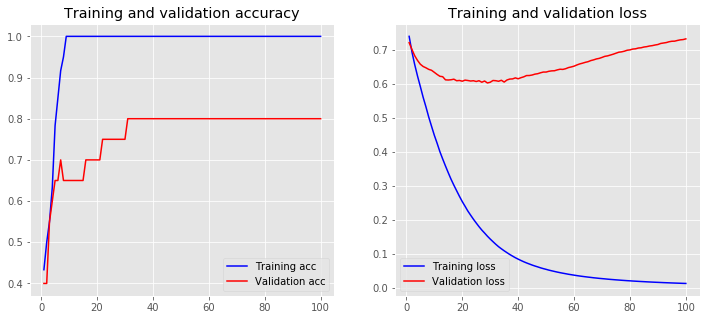

In [28]:
plot_history(history)